In [ ]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

# ============================
# 1. Load the ensemble model
# ============================
with open('/content/ensemble_forecast_model.pkl', 'rb') as f:
    model_components = pickle.load(f)

mlp_model = model_components['mlp_model']
lstm_model = model_components['lstm_model']
cnn_model = model_components['cnn_model']
meta_model = model_components['meta_model']
scaler = model_components['scaler']
sequence_length = model_components['sequence_length']
feature_columns = model_components['feature_columns']

print("✅ Ensemble model components loaded")

# ============================
# 2. Load the last 30 days CSV
# ============================
df_last30 = pd.read_csv('/content/sku1_last_30days.csv')
print("✅ 30-day context data loaded")
print(df_last30.tail())

# Ensure order of columns is consistent
df_last30 = df_last30[feature_columns]

# ============================
# 3. Get user input for the new day
# ============================
print("\nPlease input numeric values for the next day 👇")

user_values = []
for col in feature_columns:
    val = float(input(f"Enter value for {col}: "))
    user_values.append(val)

user_input = np.array([user_values])  # shape (1,6)
print("\n📥 Your input:", user_input)

# ============================
# 4. Prepare full 30-day + new-day sequence
# ============================
# Drop oldest day, append new one → to simulate real next-day prediction
combined = pd.concat([
    df_last30.iloc[1:],  # keep last 29
    pd.DataFrame(user_input, columns=feature_columns)  # append new input
], ignore_index=True)

# Scale
scaled_sequence = scaler.transform(combined.values)
X_seq = np.expand_dims(scaled_sequence, axis=0)  # shape (1,30,6)

# ============================
# 5. Predict using ensemble
# ============================
mlp_pred = mlp_model.predict(X_seq, verbose=0).flatten()[0]
lstm_pred = lstm_model.predict(X_seq, verbose=0).flatten()[0]
cnn_pred = cnn_model.predict(X_seq, verbose=0).flatten()[0]

meta_input = np.array([[mlp_pred, lstm_pred, cnn_pred]])
ensemble_pred = meta_model.predict(meta_input, verbose=0).flatten()[0]

print(f"\n🎯 Predicted Units Sold for Next Day: {ensemble_pred:.2f}")

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Ensemble model components loaded
✅ 30-day context data loaded
    Units_Sold  Inventory_Level  Order_Quantity  Unit_Cost  Unit_Price  \
25        23.0            624.0             0.0      13.95       20.48   
26        10.0            441.0             0.0       6.93       10.70   
27        19.0            435.0             0.0       6.06        8.41   
28        14.0            363.0             0.0      11.46       19.92   
29        29.0            570.0             0.0      19.41       23.81   

    Demand_Forecast  
25            24.73  
26            13.25  
27            18.32  
28            10.96  
29            27.63  

Please input numeric values for the next day 👇
Enter value for Units_Sold: 15
Enter value for Inventory_Level: 624
Enter value for Order_Quantity: 0
Enter value for Unit_Cost: 14
Enter value for Unit_Price: 21
Enter value for Demand_Forecast: 17.3


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



📥 Your input: [[ 15.  624.    0.   14.   21.   17.3]]



🎯 Predicted Units Sold for Next Day: 14.41


In [ ]:
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

Pandas version: 2.2.2
NumPy version: 2.0.2
TensorFlow version: 2.19.0
Scikit-learn version: 1.6.1


# Comparsion with Prophet

In [ ]:
# --- 1️⃣ Setup and Load Data ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load your same SKU data (the cleaned one)
df = pd.read_csv("/content/supply_chain_dataset1.csv")

sku_id = "SKU_1"
df_sku = df[df["SKU_ID"] == sku_id].copy()
df_sku = df_sku.sort_values("Date")

# Convert Date to datetime
df_sku["Date"] = pd.to_datetime(df_sku["Date"])

# Prophet expects columns: ds (date) and y (target)
prophet_df = df_sku[["Date", "Units_Sold"]].rename(columns={"Date": "ds", "Units_Sold": "y"})

# Train-test split (last 10% for test)
n = len(prophet_df)
holdout_size = int(0.1 * n)
train_df = prophet_df.iloc[:-holdout_size]
test_df = prophet_df.iloc[-holdout_size:]

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (1643, 2), Test shape: (182, 2)


In [ ]:
# --- 2️⃣ Install and Import Prophet ---
!pip install prophet -q

from prophet import Prophet

In [ ]:
# --- 3️⃣ Train Prophet Model ---
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

model_prophet.fit(train_df)
print("✅ Prophet model trained successfully")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_i1aevlv/i6imhpew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_i1aevlv/x86u7k0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57571', 'data', 'file=/tmp/tmp_i1aevlv/i6imhpew.json', 'init=/tmp/tmp_i1aevlv/x86u7k0f.json', 'output', 'file=/tmp/tmp_i1aevlv/prophet_modelmdoegmey/prophet_model-20251020103157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:31:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:31:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet model trained successfully


📊 Prophet MAE: 10.6288, RMSE: 12.2874


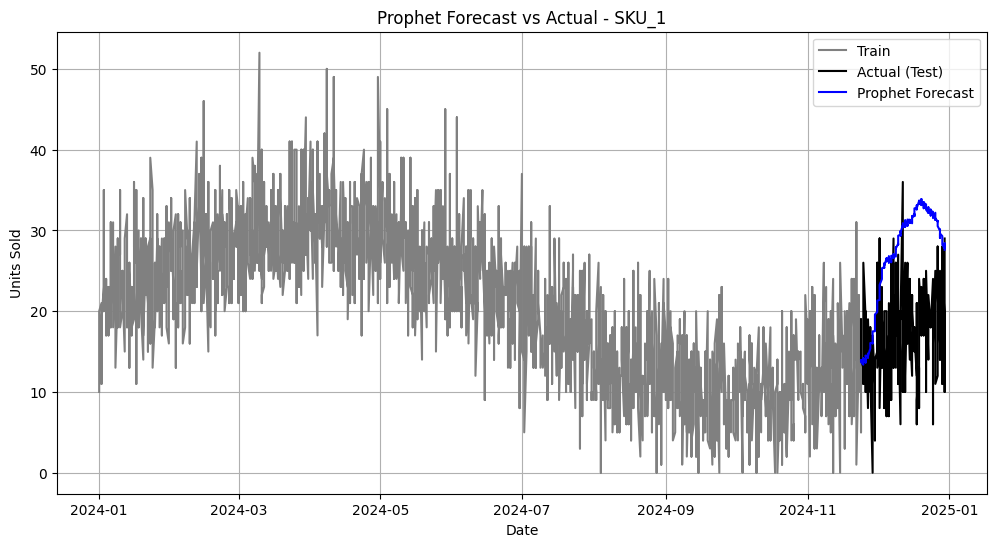

In [ ]:
# --- 4️⃣ Forecast and Evaluate Prophet ---
# Make future dataframe for same length as test set
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='D')

forecast = model_prophet.predict(future)
forecast_tail = forecast.tail(len(test_df))

# Align forecast with actual test data
y_true = test_df['y'].values
y_pred = forecast_tail['yhat'].values

mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"📊 Prophet MAE: {mae_prophet:.4f}, RMSE: {rmse_prophet:.4f}")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train_df['ds'], train_df['y'], label='Train', color='gray')
plt.plot(test_df['ds'], y_true, label='Actual (Test)', color='black')
plt.plot(test_df['ds'], y_pred, label='Prophet Forecast', color='blue')
plt.title(f'Prophet Forecast vs Actual - {sku_id}')
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 640x480 with 0 Axes>